In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
!pip install transformers==4.38.2

In [ ]:
!pip install pandas==1.5.3

In [ ]:
!pip install numpy==1.26.4

In [ ]:
!pip install scikit-learn==1.4.2

In [ ]:
!pip install matplotlib==3.7.1

In [ ]:

!pip install seaborn==0.12.2

In [ ]:
!pip install gdown==5.1.0

In [ ]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 11.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer, BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import random, os, gdown, re
from wordcloud import WordCloud
import gc

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set paths for synthetic data on Google Drive
synthetic_folder = '/content/drive/MyDrive/synthetic_data'
if not os.path.exists(synthetic_folder):
    os.makedirs(synthetic_folder)
synthetic_positive_path = os.path.join(synthetic_folder, 'synthetic_positive.csv')
synthetic_negative_path = os.path.join(synthetic_folder, 'synthetic_negative.csv')

In [ ]:
# TPU Setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU is ready")
except ValueError:
    strategy = tf.distribute.get_strategy()
    print("TPU not detected. Using CPU/GPU")
print("Distribution strategy:", strategy)


TPU not detected. Using CPU/GPU
Distribution strategy: <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7c789d48eb10>


In [ ]:
# Load real data from Google Drive
def load_real_data_from_drive():
    file_url = "https://drive.google.com/uc?id=1KRiUmF7XP32mHTFHxPz_p9si4YE0NMK0"
    output_path = "IMDB_Dataset.csv"
    print("Downloading dataset...")
    gdown.download(file_url, output_path, quiet=False)
    print("Loading dataset...")
    real_data = pd.read_csv(output_path)
    real_data['label'] = real_data['sentiment'].map({'positive': 1, 'negative': 0})
    print(f"Loaded dataset with {len(real_data)} entries.")
    return real_data[['review', 'label']]



In [ ]:
# Load GPT-2 model and tokenizer (PyTorch)
def load_gpt2_model():
    model_name = "gpt2-medium"
    model = TFGPT2LMHeadModel.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    # Set padding_side to 'left' to avoid issues with decoder-only models.
    tokenizer.padding_side = "left"
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer

In [ ]:
# Function for dynamic prompt generation
def generate_dynamic_prompt(sentiment):
    if sentiment == 'positive':
        adjectives = ["incredibly good", "amazing", "inspiring", "stunning", "fantastic"]
        reasons = [
            "the plot kept me on the edge of my seat from start to finish",
            "the acting was top-notch",
            "the visual effects were breathtaking",
            "the music perfectly complemented the movie's atmosphere",
            "every scene evoked strong emotions"
        ]
        prompt = f"Write an enthusiastic and detailed movie review. The movie was {random.choice(adjectives)} because {random.choice(reasons)}."
    elif sentiment == 'negative':
        adjectives = ["terrible", "disgusting", "disappointing", "dull", "uninteresting"]
        reasons = [
            "the plot was predictable and boring",
            "the actors failed to convey any emotion",
            "the visual effects looked unconvincing",
            "the music detracted from the movie experience",
            "every scene felt meaningless"
        ]
        prompt = f"Write a critical and detailed movie review. The movie was {random.choice(adjectives)} because {random.choice(reasons)}."
    else:
        raise ValueError("Sentiment must be 'positive' or 'negative'.")
    return prompt


In [ ]:

# Function to clean the generated text by removing prompt remnants and undesired patterns
def clean_generated_text(text):
    patterns = [
        r"Write an enthusiastic and detailed movie review\.?",
        r"Write a critical and detailed movie review\.?",
        r"Write an? .* movie review\.?",
    ]
    for pattern in patterns:
        text = re.sub(pattern, "", text, flags=re.IGNORECASE)
    text = " ".join(text.split())
    return text

In [ ]:
def generate_synthetic_data_batch(model, tokenizer, num_samples, sentiment, batch_size=32, save_path=None):
    synthetic_data = []
    prompts = []
    # Generate all prompts first
    for i in range(num_samples):
        prompt = generate_dynamic_prompt(sentiment).strip()
        if prompt:
            prompts.append(prompt)
        else:
            print(f"Empty prompt in iteration {i}. Skipping.")
    # Process prompts in batches
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i+batch_size]
        # Tokenize the batch with padding
        inputs = tokenizer(batch_prompts, return_tensors="tf", padding=True)
        # Calculate prompt lengths from the attention mask
        prompt_lens = tf.reduce_sum(inputs["attention_mask"], axis=1)  # shape: (batch_size,)
        max_prompt_len = int(tf.reduce_max(prompt_lens).numpy())
        # Generate outputs with additional 50 tokens beyond the longest prompt in the batch
        batch_outputs = model.generate(
            **inputs,
            max_length=max_prompt_len + 50,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer.eos_token_id,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
            do_sample=True
        )
        # Decode outputs for each prompt in the batch
        for j in range(len(batch_prompts)):
            current_prompt_len = int(prompt_lens[j].numpy())
            output_ids = batch_outputs[j]
            if output_ids.shape[0] < current_prompt_len:
                print(f"Output length is shorter than prompt in batch index {j}: {batch_prompts[j]}")
                continue
            generated_ids = output_ids[current_prompt_len:]
            generated_text = tokenizer.decode(generated_ids.numpy().tolist(), skip_special_tokens=True)
            generated_text = clean_generated_text(generated_text)
            label = 1 if sentiment == 'positive' else 0
            synthetic_data.append({'review': generated_text, 'label': label})
    if save_path:
        df = pd.DataFrame(synthetic_data)
        df.to_csv(save_path, index=False)
        print(f"Synthetic {sentiment} data saved to {save_path}")
    return synthetic_data


In [ ]:
def compute_perplexity(model, tokenizer, texts):
    if len(texts) == 0:
        print("No texts provided for perplexity calculation. Returning infinity.")
        return np.inf

    total_loss = 0.0
    # Loop through each text and accumulate the loss.
    for text in texts:
        # Ensure the text is a string.
        text = str(text)
        # Tokenize the text with truncation (max 100 tokens).
        inputs = tokenizer(text, return_tensors="tf", truncation=True, max_length=100)
        # Compute the model outputs with labels equal to input_ids.
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss.numpy()  # Convert TF tensor to numpy scalar.
        total_loss += loss

    avg_loss = total_loss / len(texts)
    perplexity = np.exp(avg_loss)
    # Convert to Python float to avoid formatting errors.
    return float(perplexity)


In [ ]:
def plot_word_map(texts):
    if not texts or not any(text.strip() for text in texts):
        print("No text available to generate word cloud.")
        return
    all_text = " ".join(texts)
    if not all_text.strip():
        print("No text available to generate word cloud.")
        return
    try:
        wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(all_text)
    except ValueError as e:
        print(f"Word cloud generation error: {e}")
        return
    if len(wc.words_) == 0:
        print("Word cloud generation failed: no words found.")
        return
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Map for Synthetic Data")
    plt.show()

In [ ]:
# This function handles synthetic data generation separately.
def generate_and_save_synthetic_data():
    # Load GPT-2 model and tokenizer
    gpt2_model, gpt2_tokenizer = load_gpt2_model()

    # Generate synthetic positive reviews in batches
    print("Generating synthetic positive reviews...")
    synthetic_data_positive = generate_synthetic_data_batch(
        gpt2_model, gpt2_tokenizer, num_samples=5000, sentiment='positive', batch_size=32, save_path=synthetic_positive_path
    )

    # Generate synthetic negative reviews in batches
    print("Generating synthetic negative reviews...")
    synthetic_data_negative = generate_synthetic_data_batch(
        gpt2_model, gpt2_tokenizer, num_samples=5000, sentiment='negative', batch_size=32, save_path=synthetic_negative_path
    )

    synthetic_texts = [item['review'] for item in (synthetic_data_positive + synthetic_data_negative)]
    if len(synthetic_texts) > 0:
        perplexity = compute_perplexity(gpt2_model, gpt2_tokenizer, synthetic_texts)
        print(f"Perplexity of synthetic data: {perplexity:.2f}")
    else:
        print("No synthetic texts generated to compute perplexity.")
    if any(text.strip() for text in synthetic_texts):
        plot_word_map(synthetic_texts)
    else:
        print("No text available to generate word cloud.")

In [ ]:
# Prepare data with balancing and validation split
def prepare_data_for_training(real_data, synthetic_data, real_ratio):
    total_samples = len(real_data)
    real_count = int(real_ratio * total_samples)
    synthetic_count = total_samples - real_count
    print(f"Using {real_count} real samples and {synthetic_count} synthetic samples.")

    if real_count > len(real_data):
        real_count = len(real_data)
    if synthetic_count > len(synthetic_data):
        synthetic_count = len(synthetic_data)

    real_sample = real_data.sample(real_count, random_state=42) if real_count > 0 else pd.DataFrame()
    synthetic_sample = pd.DataFrame(synthetic_data).sample(synthetic_count, random_state=42) if synthetic_count > 0 else pd.DataFrame()

    # Drop rows with missing or empty 'review' and missing 'label'
    combined_data = pd.concat([real_sample, synthetic_sample], ignore_index=True)
    combined_data = combined_data.dropna(subset=['review', 'label'])
    combined_data = combined_data[combined_data['review'].str.strip() != '']

    # Balance classes
    pos_samples = combined_data[combined_data['label'] == 1]
    neg_samples = combined_data[combined_data['label'] == 0]
    min_samples = min(len(pos_samples), len(neg_samples))
    pos_balanced = resample(pos_samples, replace=False, n_samples=min_samples, random_state=42)
    neg_balanced = resample(neg_samples, replace=False, n_samples=min_samples, random_state=42)
    balanced_data = pd.concat([pos_balanced, neg_balanced]).sample(frac=1, random_state=42)

    X = balanced_data['review']
    y = balanced_data['label'].astype(int)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2 of total
    return X_train, X_val, X_test, y_train, y_val, y_test




In [ ]:
# Logistic Regression model
def logistic_regression_model(X_train, y_train):
    from sklearn.linear_model import LogisticRegression
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_tfidf, y_train)
    return model, vectorizer



In [ ]:
# Preprocess text for LSTM
def preprocess_text_for_lstm(X_train, X_test, X_val, vocab_size=5000, max_length=100):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post', truncating='post')
    X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post', truncating='post')
    X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length, padding='post', truncating='post')
    return X_train_pad, X_test_pad, X_val_pad, tokenizer


In [ ]:
# LSTM model
def lstm_model(vocab_size, max_length):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_length),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name, ratio):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {model_name} at {ratio*100}% Real Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
# Evaluate model with additional metrics
def evaluate_model(model, X_test, y_test, model_type='logistic', model_name="", ratio=0):
    """
    Evaluates a model on the test set and prints metrics along with a confusion matrix.

    Parameters:
        model: Trained model.
        X_test: Test input data.
        y_test: True labels.
        model_type (str): One of 'bert', 'logistic', or 'lstm'.
        model_name (str): Name of the model for display.
        ratio (float): Proportion of real data used.

    Returns:
        Tuple of (accuracy, precision, recall, f1_score, auc_roc)
    """
    if model_type == 'bert':
        predictions = model.predict(X_test)
        y_pred = np.argmax(predictions.logits, axis=1)
        y_pred_proba = tf.nn.softmax(predictions.logits, axis=1)[:, 1].numpy()
    elif model_type == 'logistic':
        # For logistic regression, predict returns probability estimates.
        y_pred_proba = model.predict(X_test)
        y_pred = np.round(y_pred_proba)
    elif model_type == 'lstm':
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC-ROC: {auc:.3f}")
    plot_confusion_matrix(y_test, y_pred, model_name, ratio)

    return acc, prec, rec, f1, auc

In [ ]:
generate_and_save_synthetic_data()

In [ ]:
real_data = load_real_data_from_drive()

# Load synthetic data from Google Drive (assumes data was generated previously)
print("Loading synthetic data from Google Drive...")
synthetic_data_positive = pd.read_csv(synthetic_positive_path).to_dict('records')
synthetic_data_negative = pd.read_csv(synthetic_negative_path).to_dict('records')
synthetic_data = synthetic_data_positive + synthetic_data_negative

Downloading...
From: https://drive.google.com/uc?id=1KRiUmF7XP32mHTFHxPz_p9si4YE0NMK0
To: /content/IMDB_Dataset.csv
100%|██████████| 66.2M/66.2M [00:01<00:00, 63.9MB/s]


Loading dataset...
Loaded dataset with 50000 entries.
Loading synthetic data from Google Drive...



=== Logistic Regression Experiments ===

--- Logistic Regression: 0% real data ---
Using 0 real samples and 50000 synthetic samples.
Accuracy: 0.940
Precision: 0.955
Recall: 0.923
F1 Score: 0.939
AUC-ROC: 0.940


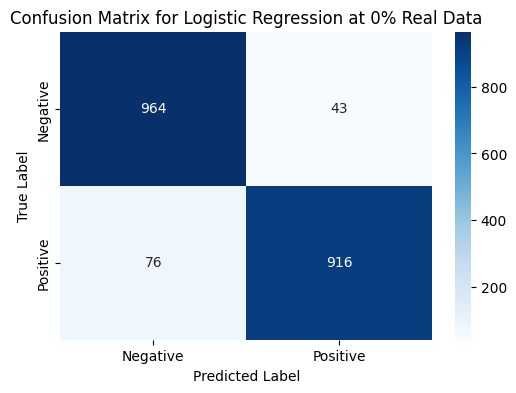


--- Logistic Regression: 25% real data ---
Using 12500 real samples and 37500 synthetic samples.
Accuracy: 0.896
Precision: 0.897
Recall: 0.897
F1 Score: 0.897
AUC-ROC: 0.896


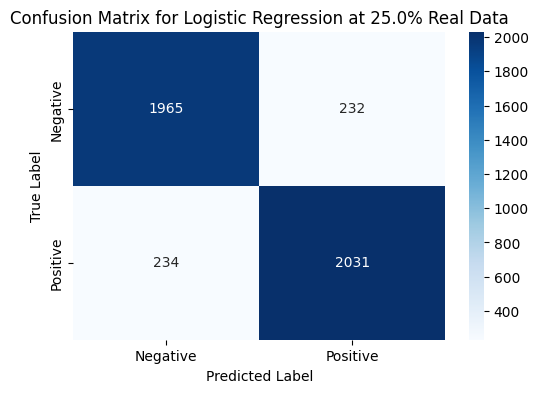


--- Logistic Regression: 50% real data ---
Using 25000 real samples and 25000 synthetic samples.
Accuracy: 0.892
Precision: 0.887
Recall: 0.900
F1 Score: 0.893
AUC-ROC: 0.892


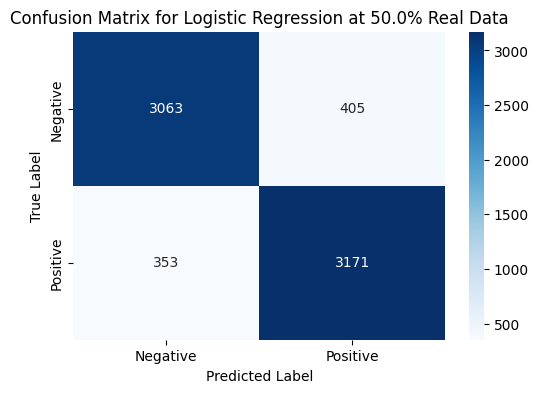


--- Logistic Regression: 75% real data ---
Using 37500 real samples and 12500 synthetic samples.
Accuracy: 0.887
Precision: 0.885
Recall: 0.889
F1 Score: 0.887
AUC-ROC: 0.887


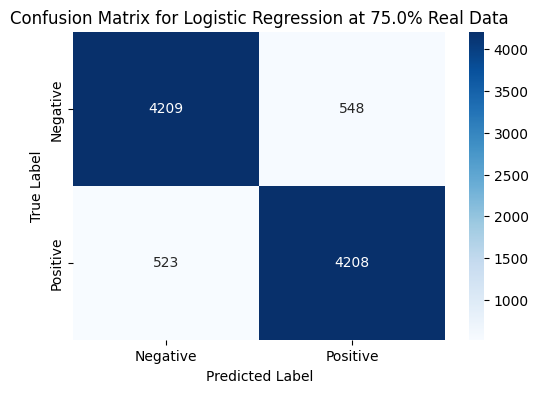


--- Logistic Regression: 100% real data ---
Using 50000 real samples and 0 synthetic samples.
Accuracy: 0.893
Precision: 0.889
Recall: 0.899
F1 Score: 0.894
AUC-ROC: 0.893


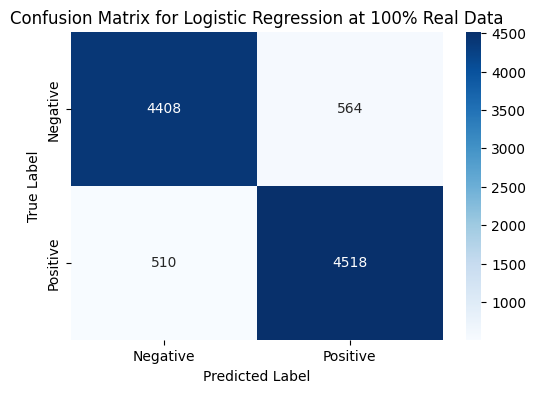

Logistic Regression Results:
{0: {'accuracy': 0.9404702351175588, 'f1_score': 0.93900563813429, 'auc': 0.940343002210334}, 0.25: {'accuracy': 0.8955625280143433, 'f1_score': 0.8970848056537103, 'auc': 0.8955450991267442}, 0.5: {'accuracy': 0.8915903890160183, 'f1_score': 0.8932394366197183, 'auc': 0.8915238660063078}, 0.75: {'accuracy': 0.8871205733558178, 'f1_score': 0.887108675028987, 'auc': 0.8871269462079867}, 1: {'accuracy': 0.8926, 'f1_score': 0.8937685459940653, 'auc': 0.8925663908820181}}


In [ ]:
print("\n=== Logistic Regression Experiments ===")
logistic_results = {}
proportions = [0, 0.25, 0.5, 0.75, 1]

for ratio in proportions:
    print(f"\n--- Logistic Regression: {int(ratio*100)}% real data ---")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=ratio)
    model, vectorizer = logistic_regression_model(X_train, y_train)
    X_test_tfidf = vectorizer.transform(X_test)
    acc, prec, rec, f1, auc = evaluate_model(
        model, X_test_tfidf, y_test,
        model_type='logistic',
        model_name='Logistic Regression',
        ratio=ratio
    )
    logistic_results[ratio] = {"accuracy": acc, "f1_score": f1, "auc": auc}

print("Logistic Regression Results:")
print(logistic_results)


=== LSTM Experiments ===

--- LSTM: 0% real data ---
Using 0 real samples and 50000 synthetic samples.
Epoch 1/10
188/188 [==============================] - 31s 136ms/step - loss: 0.2756 - accuracy: 0.8805 - val_loss: 0.1449 - val_accuracy: 0.9390
Epoch 2/10
188/188 [==============================] - 25s 134ms/step - loss: 0.1017 - accuracy: 0.9601 - val_loss: 0.1161 - val_accuracy: 0.9505
Epoch 3/10
188/188 [==============================] - 25s 136ms/step - loss: 0.0627 - accuracy: 0.9750 - val_loss: 0.1295 - val_accuracy: 0.9535
Epoch 4/10
188/188 [==============================] - 25s 134ms/step - loss: 0.0376 - accuracy: 0.9860 - val_loss: 0.1369 - val_accuracy: 0.9530
Epoch 5/10
63/63 [==============================] - 2s 20ms/step
Accuracy: 0.950
Precision: 0.966
Recall: 0.933
F1 Score: 0.949
AUC-ROC: 0.992


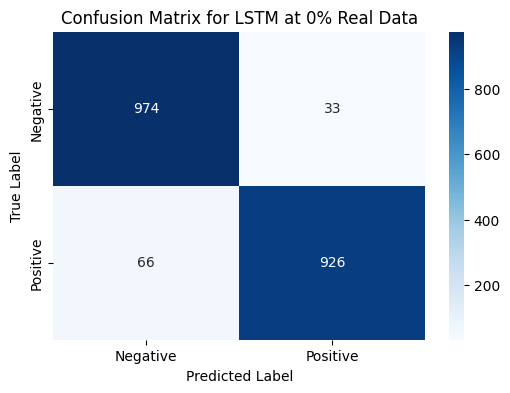


--- LSTM: 25.0% real data ---
Using 12500 real samples and 37500 synthetic samples.
Epoch 1/10
419/419 [==============================] - 61s 132ms/step - loss: 0.4231 - accuracy: 0.7841 - val_loss: 0.3692 - val_accuracy: 0.8169
Epoch 2/10
419/419 [==============================] - 55s 131ms/step - loss: 0.2605 - accuracy: 0.8878 - val_loss: 0.3014 - val_accuracy: 0.8574
Epoch 3/10
419/419 [==============================] - 55s 132ms/step - loss: 0.1984 - accuracy: 0.9200 - val_loss: 0.3398 - val_accuracy: 0.8545
Epoch 4/10
419/419 [==============================] - 56s 133ms/step - loss: 0.1527 - accuracy: 0.9404 - val_loss: 0.4288 - val_accuracy: 0.8449
Epoch 5/10
140/140 [==============================] - 3s 20ms/step
Accuracy: 0.859
Precision: 0.849
Recall: 0.879
F1 Score: 0.864
AUC-ROC: 0.941


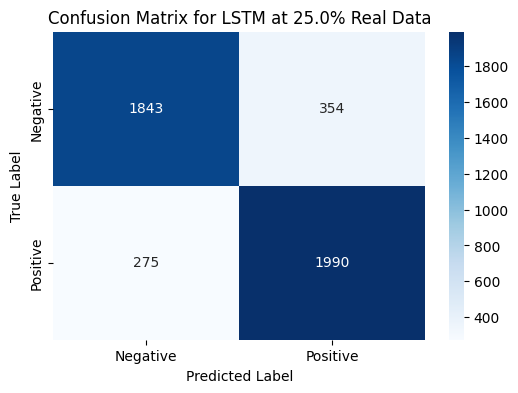


--- LSTM: 50.0% real data ---
Using 25000 real samples and 25000 synthetic samples.
Epoch 1/10
656/656 [==============================] - 93s 134ms/step - loss: 0.4227 - accuracy: 0.7973 - val_loss: 0.3439 - val_accuracy: 0.8435
Epoch 2/10
656/656 [==============================] - 86s 131ms/step - loss: 0.2925 - accuracy: 0.8769 - val_loss: 0.3356 - val_accuracy: 0.8521
Epoch 3/10
656/656 [==============================] - 86s 132ms/step - loss: 0.2403 - accuracy: 0.9013 - val_loss: 0.3653 - val_accuracy: 0.8514
Epoch 4/10
656/656 [==============================] - 86s 131ms/step - loss: 0.1860 - accuracy: 0.9259 - val_loss: 0.3993 - val_accuracy: 0.8392
Epoch 5/10
219/219 [==============================] - 5s 20ms/step
Accuracy: 0.849
Precision: 0.850
Recall: 0.850
F1 Score: 0.850
AUC-ROC: 0.932


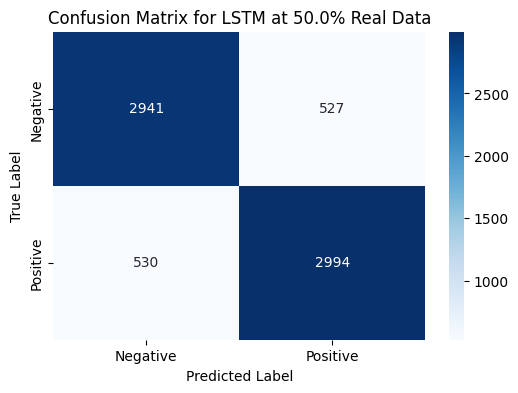


--- LSTM: 75.0% real data ---
Using 37500 real samples and 12500 synthetic samples.
Epoch 1/10
890/890 [==============================] - 123s 133ms/step - loss: 0.4273 - accuracy: 0.7918 - val_loss: 0.3522 - val_accuracy: 0.8392
Epoch 2/10
890/890 [==============================] - 117s 132ms/step - loss: 0.3022 - accuracy: 0.8702 - val_loss: 0.3464 - val_accuracy: 0.8456
Epoch 3/10
890/890 [==============================] - 118s 132ms/step - loss: 0.2506 - accuracy: 0.8955 - val_loss: 0.3560 - val_accuracy: 0.8420
Epoch 4/10
890/890 [==============================] - 117s 131ms/step - loss: 0.2042 - accuracy: 0.9174 - val_loss: 0.3936 - val_accuracy: 0.8412
Epoch 5/10
297/297 [==============================] - 6s 20ms/step
Accuracy: 0.839
Precision: 0.872
Recall: 0.793
F1 Score: 0.831
AUC-ROC: 0.922


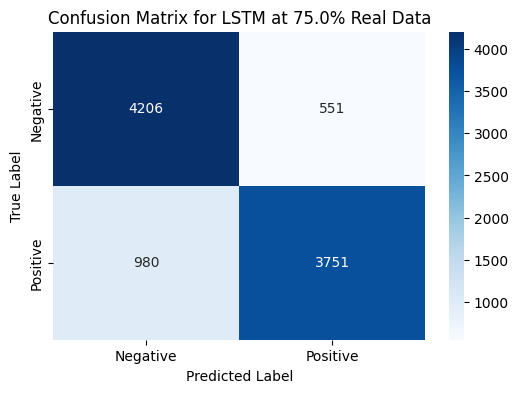


--- LSTM: 100% real data ---
Using 50000 real samples and 0 synthetic samples.
Epoch 1/10
938/938 [==============================] - 133s 135ms/step - loss: 0.4661 - accuracy: 0.7735 - val_loss: 0.3882 - val_accuracy: 0.8243
Epoch 2/10
938/938 [==============================] - 126s 134ms/step - loss: 0.3422 - accuracy: 0.8527 - val_loss: 0.3876 - val_accuracy: 0.8325
Epoch 3/10
938/938 [==============================] - 126s 135ms/step - loss: 0.2886 - accuracy: 0.8789 - val_loss: 0.4085 - val_accuracy: 0.8197
Epoch 4/10
938/938 [==============================] - 126s 134ms/step - loss: 0.2362 - accuracy: 0.9061 - val_loss: 0.4341 - val_accuracy: 0.8094
Epoch 5/10
313/313 [==============================] - 7s 20ms/step
Accuracy: 0.834
Precision: 0.833
Recall: 0.837
F1 Score: 0.835
AUC-ROC: 0.915


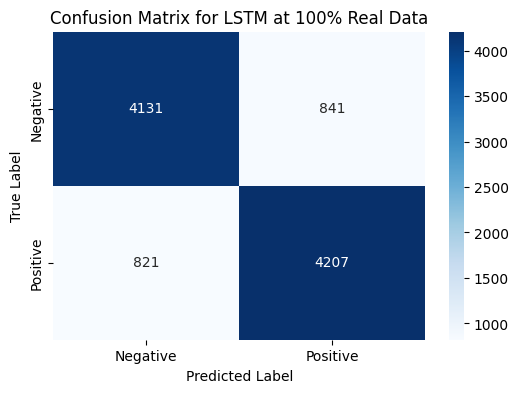

LSTM Results:
{0: {'accuracy': 0.9504752376188094, 'f1_score': 0.9492567913890313, 'auc': 0.9924680462568474}, 0.25: {'accuracy': 0.8590318242940386, 'f1_score': 0.8635278802343241, 'auc': 0.9413922858885436}, 0.5: {'accuracy': 0.8488272311212814, 'f1_score': 0.8499645138396026, 'auc': 0.9318737259876908}, 0.75: {'accuracy': 0.8386382799325464, 'f1_score': 0.8305103509354589, 'auc': 0.92247204855624}, 1: {'accuracy': 0.8338, 'f1_score': 0.835053592695514, 'auc': 0.9148122485121134}}


In [ ]:
print("\n=== LSTM Experiments ===")
lstm_results = {}

for ratio in proportions:
    print(f"\n--- LSTM: {ratio*100}% real data ---")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=ratio)
    X_train_pad, X_test_pad, X_val_pad, lstm_tokenizer = preprocess_text_for_lstm(X_train, X_test, X_val)
    with strategy.scope():
        lstm = lstm_model(vocab_size=5000, max_length=100)
    lstm.fit(
        X_train_pad, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val_pad, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )
    acc, prec, rec, f1, auc = evaluate_model(
        lstm, X_test_pad, y_test,
        model_type='lstm',
        model_name='LSTM',
        ratio=ratio
    )
    lstm_results[ratio] = {"accuracy": acc, "f1_score": f1, "auc": auc}

print("LSTM Results:")
print(lstm_results)

In [ ]:
def get_new_bert_model_and_tokenizer():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    return tokenizer, model

# Helper to prepare tf.data.Dataset
def prepare_dataset(tokenizer, X, y, batch_size=32, max_length=100):
    encodings = tokenizer(X.tolist(), truncation=True, padding=True, max_length=max_length)
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), y))
    return dataset.shuffle(1000).batch(batch_size)




--- BERT: 0% real data ---
Using 0 real samples and 50000 synthetic samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
188/188 [==============================] - 499s 3s/step - loss: 0.1928 - accuracy: 0.9253 - val_loss: 0.0924 - val_accuracy: 0.9610
Epoch 2/10
188/188 [==============================] - 460s 2s/step - loss: 0.0636 - accuracy: 0.9761 - val_loss: 0.0895 - val_accuracy: 0.9645
Epoch 3/10
188/188 [==============================] - 456s 2s/step - loss: 0.0267 - accuracy: 0.9910 - val_loss: 0.1305 - val_accuracy: 0.9600
Epoch 4/10
63/63 [==============================] - 49s 718ms/step
Accuracy: 0.972
Precision: 0.988
Recall: 0.956
F1 Score: 0.971
AUC-ROC: 0.996


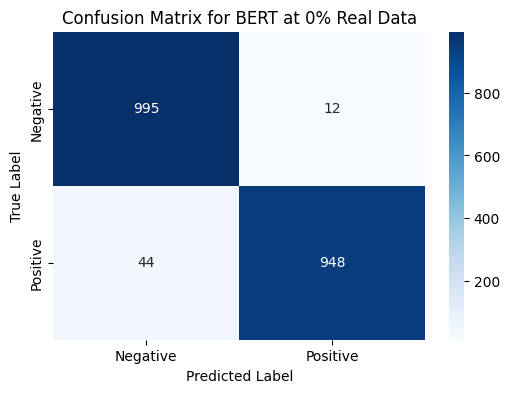

(0.9719859929964982,
 0.9875,
 0.9556451612903226,
 0.9713114754098361,
 0.9961609459589326)

In [ ]:
print("\n--- BERT: 0% real data ---")
K.clear_session()
gc.collect()
tf.keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=0.0)
bert_tokenizer, bert_model_instance = get_new_bert_model_and_tokenizer()

train_dataset = prepare_dataset(bert_tokenizer, X_train, y_train)
val_dataset = prepare_dataset(bert_tokenizer, X_val, y_val)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

bert_model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

bert_model_instance.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

evaluate_model(bert_model_instance, test_encodings, y_test, model_type='bert', model_name='BERT', ratio=0)



--- BERT: 25% real data ---
Using 12500 real samples and 37500 synthetic samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
419/419 [==============================] - 1387s 3s/step - loss: 0.3112 - accuracy: 0.8571 - val_loss: 0.2497 - val_accuracy: 0.8937
Epoch 2/10
419/419 [==============================] - 1348s 3s/step - loss: 0.1621 - accuracy: 0.9355 - val_loss: 0.2404 - val_accuracy: 0.8985
Epoch 3/10
419/419 [==============================] - 1352s 3s/step - loss: 0.0768 - accuracy: 0.9730 - val_loss: 0.3037 - val_accuracy: 0.8935
Epoch 4/10
140/140 [==============================] - 124s 857ms/step
Accuracy: 0.902
Precision: 0.911
Recall: 0.893
F1 Score: 0.902
AUC-ROC: 0.969


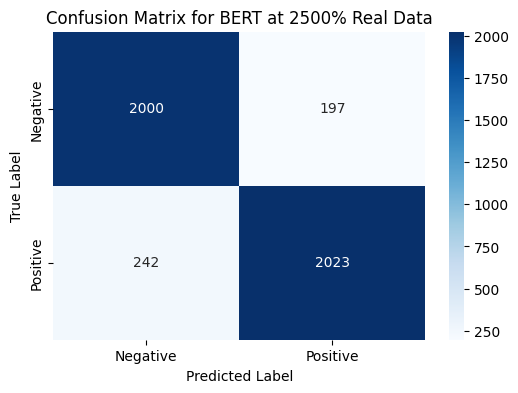

(0.9016136261766025,
 0.9112612612612613,
 0.8931567328918323,
 0.902118171683389,
 0.9690280042723319)

In [ ]:
print("\n--- BERT: 25% real data ---")
K.clear_session()
gc.collect()
tf.keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=0.25)
bert_tokenizer, bert_model_instance = get_new_bert_model_and_tokenizer()

train_dataset = prepare_dataset(bert_tokenizer, X_train, y_train)
val_dataset = prepare_dataset(bert_tokenizer, X_val, y_val)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

bert_model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

bert_model_instance.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

evaluate_model(bert_model_instance, test_encodings, y_test, model_type='bert', model_name='BERT', ratio=25)



--- BERT: 50% real data ---
Using 25000 real samples and 25000 synthetic samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
656/656 [==============================] - 2117s 3s/step - loss: 0.3227 - accuracy: 0.8516 - val_loss: 0.2604 - val_accuracy: 0.8864
Epoch 2/10
656/656 [==============================] - 2086s 3s/step - loss: 0.1812 - accuracy: 0.9256 - val_loss: 0.3023 - val_accuracy: 0.8907
Epoch 3/10
219/219 [==============================] - 192s 858ms/step
Accuracy: 0.880
Precision: 0.918
Recall: 0.837
F1 Score: 0.876
AUC-ROC: 0.960


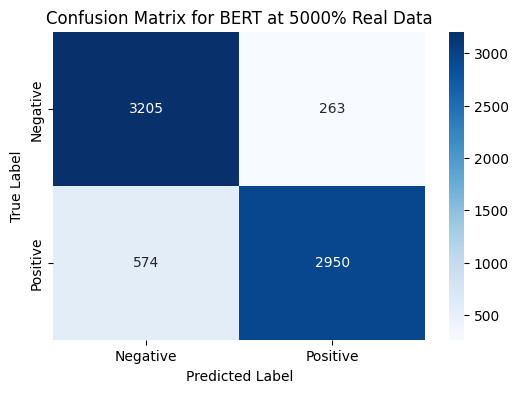

(0.8802917620137299,
 0.9181450357920946,
 0.837116912599319,
 0.8757607243580229,
 0.9599366905071436)

In [ ]:
print("\n--- BERT: 50% real data ---")
K.clear_session()
gc.collect()
tf.keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=0.5)
bert_tokenizer, bert_model_instance = get_new_bert_model_and_tokenizer()

train_dataset = prepare_dataset(bert_tokenizer, X_train, y_train)
val_dataset = prepare_dataset(bert_tokenizer, X_val, y_val)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

bert_model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

bert_model_instance.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

evaluate_model(bert_model_instance, test_encodings, y_test, model_type='bert', model_name='BERT', ratio=50)



--- BERT: 75% real data ---
Using 37500 real samples and 12500 synthetic samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
890/890 [==============================] - 2826s 3s/step - loss: 0.3219 - accuracy: 0.8547 - val_loss: 0.2737 - val_accuracy: 0.8795
Epoch 2/10
890/890 [==============================] - 2811s 3s/step - loss: 0.1904 - accuracy: 0.9240 - val_loss: 0.3007 - val_accuracy: 0.8805
Epoch 3/10
297/297 [==============================] - 261s 865ms/step
Accuracy: 0.879
Precision: 0.853
Recall: 0.914
F1 Score: 0.883
AUC-ROC: 0.956


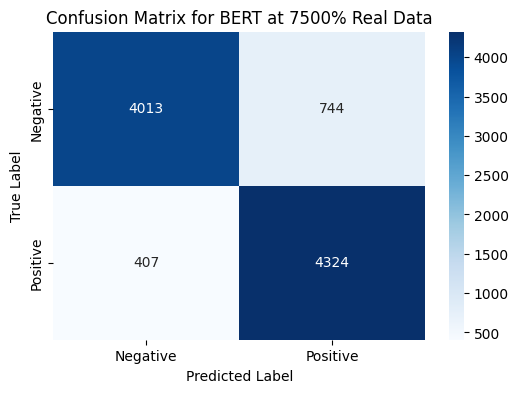

(0.8786888701517707,
 0.8531965272296764,
 0.9139716761783978,
 0.8825390345953669,
 0.9563813822720598)

In [ ]:
print("\n--- BERT: 75% real data ---")
K.clear_session()
gc.collect()
tf.keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=0.75)
bert_tokenizer, bert_model_instance = get_new_bert_model_and_tokenizer()

train_dataset = prepare_dataset(bert_tokenizer, X_train, y_train)
val_dataset = prepare_dataset(bert_tokenizer, X_val, y_val)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

bert_model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

bert_model_instance.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

evaluate_model(bert_model_instance, test_encodings, y_test, model_type='bert', model_name='BERT', ratio=75)



--- BERT: 100% real data ---
Using 50000 real samples and 0 synthetic samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
938/938 [==============================] - 3014s 3s/step - loss: 0.3647 - accuracy: 0.8346 - val_loss: 0.2917 - val_accuracy: 0.8729
Epoch 2/10
938/938 [==============================] - 2978s 3s/step - loss: 0.2237 - accuracy: 0.9100 - val_loss: 0.3356 - val_accuracy: 0.8642
Epoch 3/10
313/313 [==============================] - 272s 858ms/step
Accuracy: 0.872
Precision: 0.860
Recall: 0.891
F1 Score: 0.875
AUC-ROC: 0.948


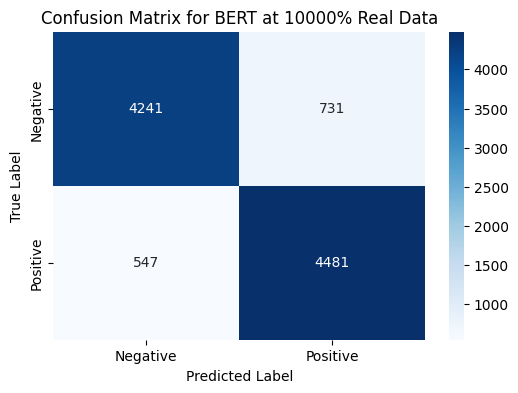

(0.8722,
 0.8597467382962395,
 0.8912092283214001,
 0.8751953125,
 0.9480853719572646)

In [ ]:
print("\n--- BERT: 100% real data ---")
K.clear_session()
gc.collect()
tf.keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=1.0)
bert_tokenizer, bert_model_instance = get_new_bert_model_and_tokenizer()

train_dataset = prepare_dataset(bert_tokenizer, X_train, y_train)
val_dataset = prepare_dataset(bert_tokenizer, X_val, y_val)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

bert_model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

bert_model_instance.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

evaluate_model(bert_model_instance, test_encodings, y_test, model_type='bert', model_name='BERT', ratio=100)
